In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# product group and starting date

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [31]:
from bktest.backtest_grid_search import *

df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=datetime.date(2023,1,30),
    roll_name='hot',
    sim_markets=all_markets,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
    
print(df.tail(10))


product         AP                                                        \
code            c1                                                         
field        close contract      expiry    high     low      mth    open   
date                                                                       
2023-01-10  8440.0   AP2305  2023-05-17  8454.0  8365.0  24281.0  8428.0   
2023-01-11  8475.0   AP2305  2023-05-17  8519.0  8407.0  24281.0  8482.0   
2023-01-12  8482.0   AP2305  2023-05-17  8593.0  8425.0  24281.0  8490.0   
2023-01-13  8786.0   AP2305  2023-05-17  8795.0  8474.0  24281.0  8482.0   
2023-01-16  8610.0   AP2305  2023-05-17  8785.0  8567.0  24281.0  8785.0   
2023-01-17  8558.0   AP2305  2023-05-17  8677.0  8538.0  24281.0  8600.0   
2023-01-18  8576.0   AP2305  2023-05-17  8630.0  8520.0  24281.0  8580.0   
2023-01-19  8623.0   AP2305  2023-05-17  8655.0  8416.0  24281.0  8567.0   
2023-01-20  8724.0   AP2305  2023-05-17  8804.0  8536.0  24281.0  8602.0   
2023-01-30  

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


# strategy portfolio config

In [18]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite2 = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
#         ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#         ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#         ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#         ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#         ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#         ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
#         ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
]


scenarios_elite_new = [ \
        ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'ryieldnma',2.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry', 'ryieldnma', 2.2, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.2, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 1.0, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.24, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.21, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
        ('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'hlbrk', 0.9, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        ('tsmom', 'macd', 0.09, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.07, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.04, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macd', 0.025, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.18, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.216, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.255, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
        ('tsmom', 'macddff', 0.4, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),                       
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


rebal = 1
ma_win = 122


# run backtest for a portfolio group

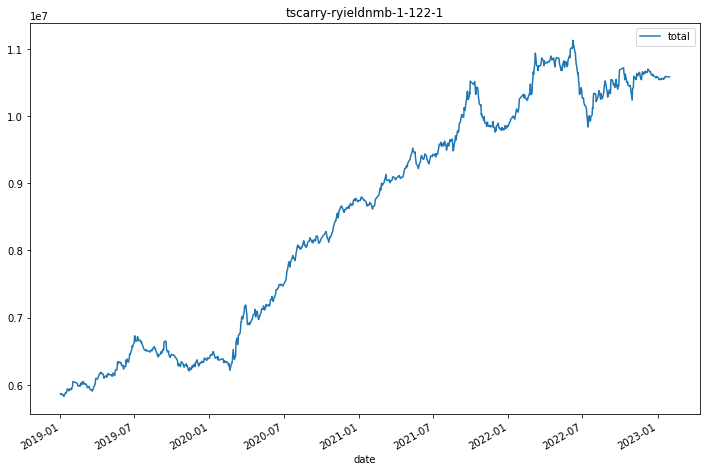

       sharpe       std  sortino
tenor                           
all      1.76  32039.01     2.54
6m       0.60  53171.13     1.00
1y       0.36  60083.86     0.59
2y       1.15  53302.98     1.83
3y       1.84  49245.63     2.85
4y       1.66  45216.86     2.60
5y       1.70  42972.38     2.62
6y       1.74  40349.30     2.66
7y       1.80  38698.80     2.74
8y       1.75  37596.92     2.66
9y       1.72  36049.76     2.60
10y      1.82  34710.89     2.72
11y      1.82  33366.21     2.70


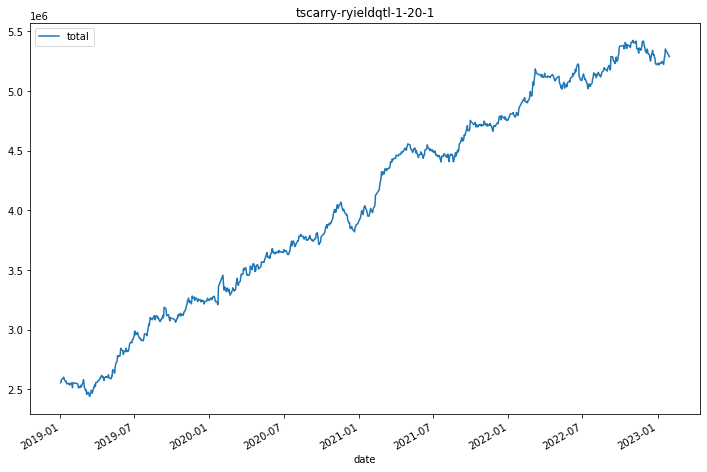

       sharpe       std  sortino
tenor                           
all      1.66  16976.01     2.63
6m       0.76  23425.44     1.29
1y       1.21  23115.83     1.98
2y       1.96  21108.23     3.25
3y       1.98  20958.17     3.23
4y       2.13  20737.66     3.71
5y       1.87  20077.40     3.22
6y       1.69  19535.94     2.85
7y       1.75  19327.44     2.88
8y       1.63  18990.34     2.67
9y       1.68  18564.53     2.73
10y      1.72  18012.01     2.78
11y      1.72  17428.79     2.75


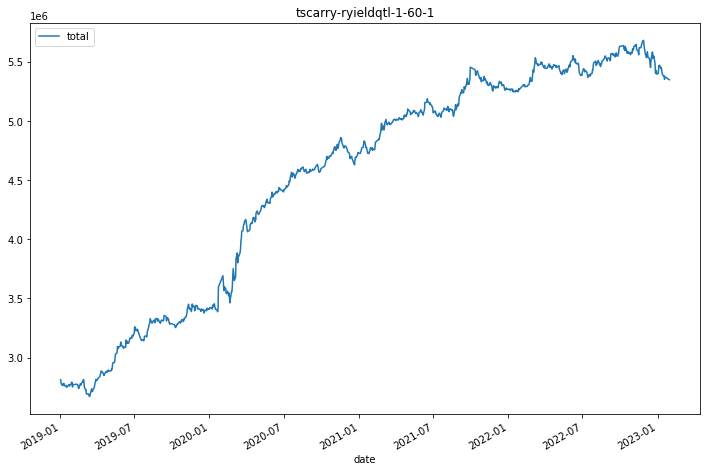

       sharpe       std  sortino
tenor                           
all      1.59  17952.55     2.47
6m      -0.78  24180.14    -1.20
1y       0.24  22309.56     0.39
2y       0.88  21280.21     1.47
3y       1.64  22974.50     2.67
4y       1.83  22528.60     3.13
5y       1.75  21748.42     2.92
6y       1.60  20901.99     2.62
7y       1.56  20513.56     2.53
8y       1.44  20013.24     2.32
9y       1.50  19705.52     2.40
10y      1.64  19051.24     2.59
11y      1.63  18483.70     2.56


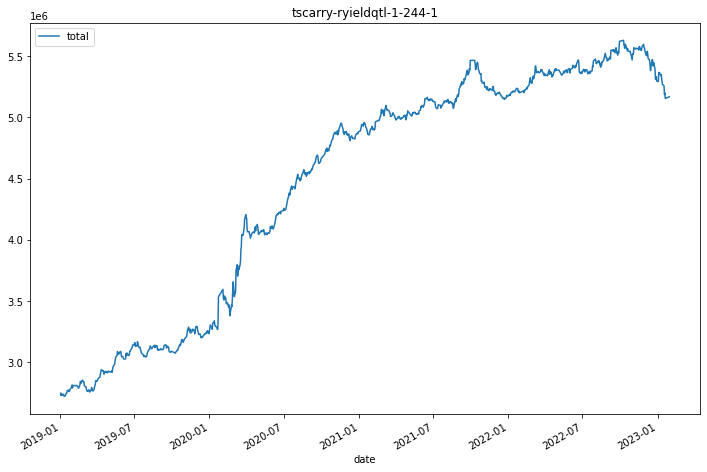

       sharpe       std  sortino
tenor                           
all      1.60  17231.00     2.40
6m      -1.51  25800.68    -2.31
1y      -0.10  22490.36    -0.14
2y       0.42  20319.95     0.63
3y       1.51  23277.44     2.23
4y       1.69  22672.37     2.65
5y       1.56  21747.61     2.43
6y       1.53  20690.06     2.40
7y       1.49  19909.46     2.34
8y       1.42  19621.74     2.23
9y       1.49  19298.34     2.38
10y      1.60  18701.68     2.54
11y      1.66  18019.32     2.61


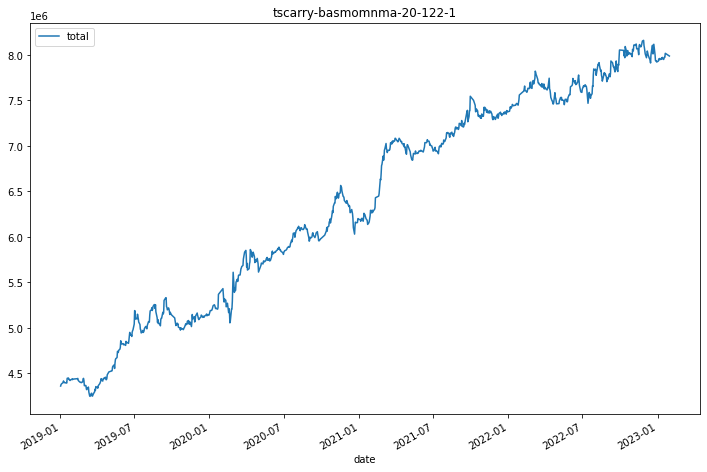

       sharpe       std  sortino
tenor                           
all      1.36  31283.21     1.97
6m       0.43  43510.77     0.78
1y       0.67  41974.82     1.22
2y       1.45  37931.28     2.54
3y       1.43  39303.92     2.19
4y       1.53  37537.04     2.36
5y       1.42  37247.02     2.19
6y       1.31  36511.89     2.03
7y       1.43  35289.49     2.21
8y       1.24  35959.15     1.88
9y       1.26  34720.59     1.90
10y      1.41  33440.26     2.10
11y      1.41  32340.08     2.08


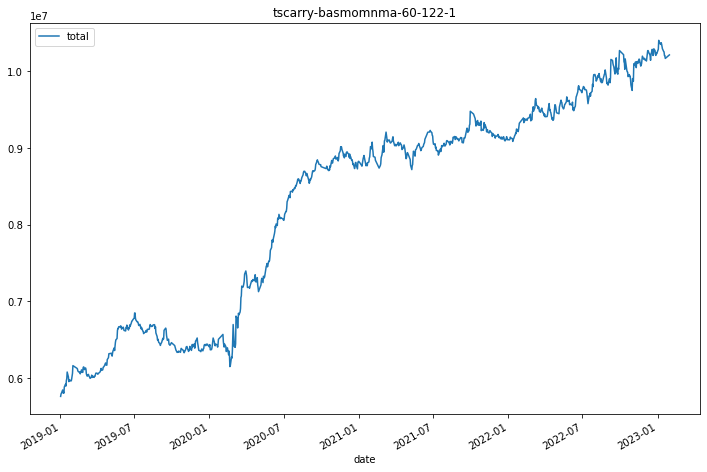

       sharpe       std  sortino
tenor                           
all      1.39  39143.90     2.07
6m       0.54  62167.30     1.04
1y       1.08  54358.56     2.05
2y       0.82  47523.44     1.43
3y       1.59  50206.15     2.63
4y       1.48  46054.72     2.44
5y       1.44  45895.23     2.25
6y       1.50  44380.54     2.36
7y       1.62  42959.37     2.56
8y       1.44  44608.51     2.25
9y       1.41  43366.83     2.21
10y      1.50  41918.50     2.33
11y      1.45  40676.42     2.22


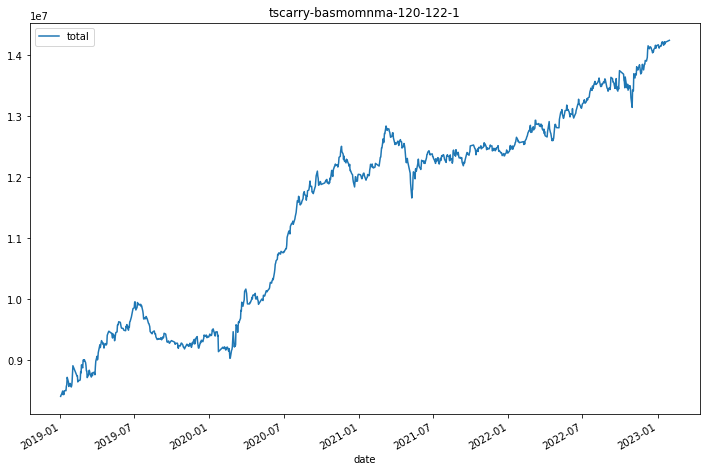

       sharpe       std  sortino
tenor                           
all      1.51  50240.55     2.23
6m       1.35  71421.56     2.22
1y       1.76  62611.95     2.90
2y       1.12  59258.91     1.71
3y       1.85  59277.99     2.85
4y       1.60  57117.64     2.42
5y       1.64  56682.93     2.48
6y       1.73  54815.35     2.67
7y       1.97  55532.34     3.12
8y       1.68  58157.24     2.64
9y       1.62  56032.42     2.52
10y      1.64  54036.36     2.55
11y      1.55  52494.23     2.39


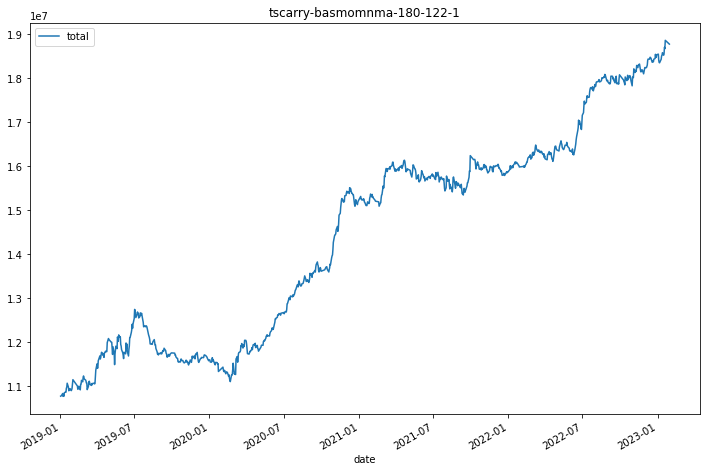

       sharpe       std  sortino
tenor                           
all      1.47  68258.50     2.13
6m       1.99  67537.92     3.10
1y       2.74  66693.59     4.76
2y       1.60  69333.61     2.86
3y       2.34  68201.01     4.00
4y       1.80  70265.01     3.05
5y       1.79  71807.83     2.93
6y       1.79  68981.16     2.92
7y       2.06  76468.06     3.46
8y       1.61  80716.68     2.56
9y       1.66  76830.70     2.57
10y      1.65  73815.78     2.54
11y      1.54  71423.43     2.34


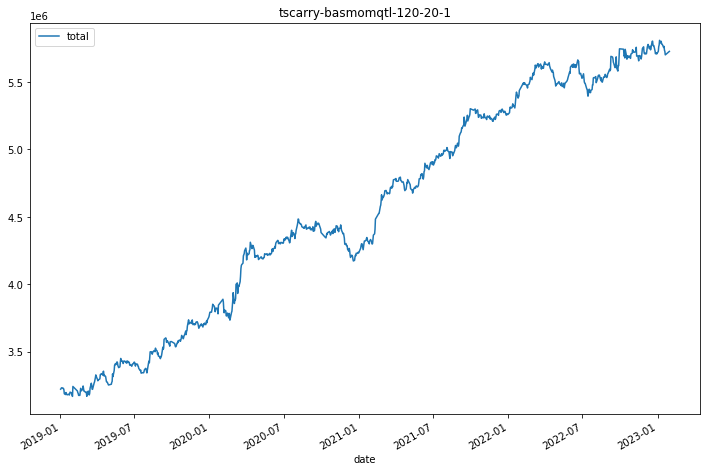

       sharpe       std  sortino
tenor                           
all      1.65  18488.36     2.67
6m       0.98  26138.14     1.51
1y       0.81  23483.74     1.35
2y       2.10  21613.87     3.53
3y       1.83  22038.87     2.91
4y       1.93  21228.27     3.22
5y       1.67  20595.16     2.75
6y       1.78  19911.05     2.90
7y       1.73  19706.62     2.84
8y       1.57  19337.14     2.54
9y       1.63  18954.06     2.65
10y      1.70  18436.87     2.76
11y      1.75  17952.67     2.84


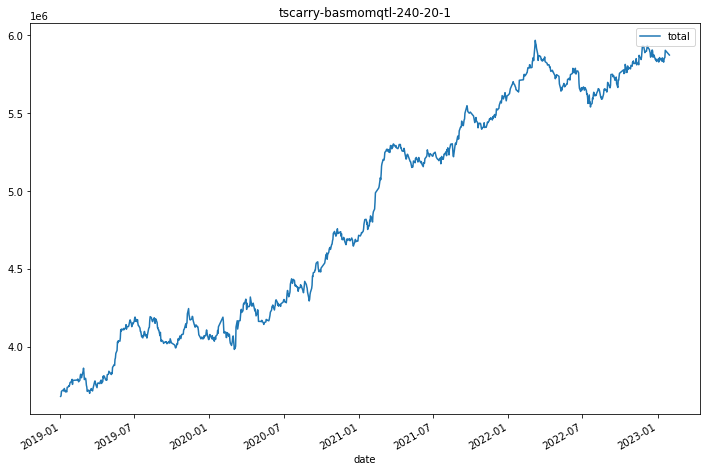

       sharpe       std  sortino
tenor                           
all      1.52  20568.88     2.45
6m       1.49  21003.27     2.84
1y       0.50  21349.30     0.84
2y       1.65  20336.44     2.77
3y       1.78  21114.57     2.86
4y       1.65  20452.38     2.73
5y       1.76  19659.42     2.94
6y       1.61  18988.81     2.64
7y       1.29  19123.10     2.02
8y       1.33  18872.77     2.11
9y       1.47  18968.58     2.35
10y      1.59  18631.57     2.56
11y      1.59  18121.59     2.56


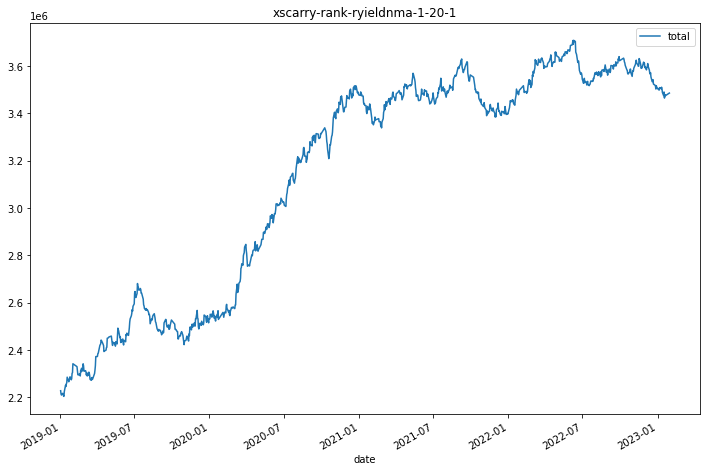

       sharpe       std  sortino
tenor                           
all      1.55  12078.82     2.42
6m      -0.64  12159.47    -1.15
1y      -0.06  13229.52    -0.09
2y       0.15  13941.02     0.23
3y       1.36  15108.60     2.16
4y       1.29  15163.48     2.13
5y       1.45  14700.89     2.35
6y       1.54  14226.23     2.50
7y       1.39  14225.87     2.30
8y       1.45  13823.36     2.38
9y       1.45  13448.55     2.37
10y      1.52  13045.86     2.48
11y      1.58  12531.27     2.52


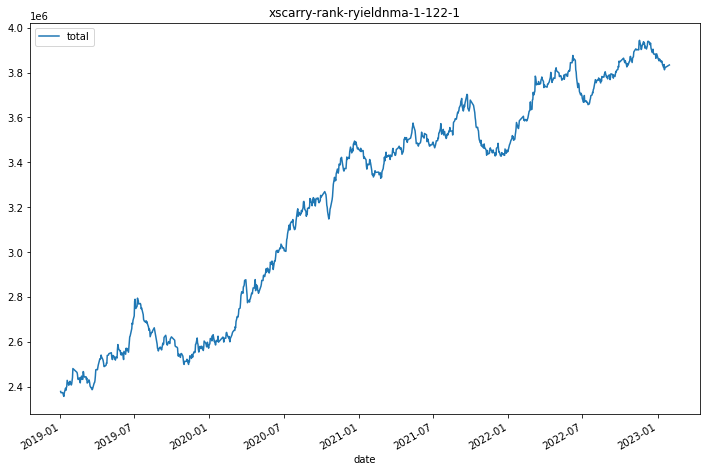

       sharpe       std  sortino
tenor                           
all      1.75  12180.73     2.75
6m       1.14  12192.58     1.92
1y       1.14  14354.72     1.71
2y       0.97  14657.60     1.48
3y       1.75  15171.07     2.80
4y       1.52  15163.73     2.57
5y       1.72  14728.58     2.90
6y       1.77  14242.96     2.95
7y       1.62  14225.28     2.73
8y       1.69  13787.31     2.80
9y       1.65  13377.33     2.72
10y      1.75  12977.29     2.86
11y      1.80  12445.61     2.86


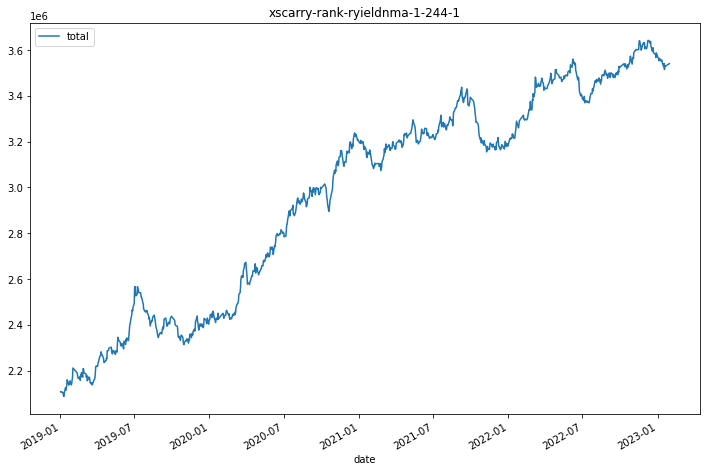

       sharpe       std  sortino
tenor                           
all      1.70  12112.96     2.71
6m       1.10  12528.45     1.87
1y       1.14  14388.49     1.80
2y       0.88  14556.59     1.35
3y       1.61  14838.23     2.59
4y       1.52  14897.91     2.59
5y       1.68  14545.48     2.82
6y       1.70  14025.47     2.83
7y       1.56  14004.30     2.63
8y       1.57  13532.03     2.62
9y       1.61  13059.85     2.65
10y      1.66  12647.85     2.70
11y      1.70  12138.22     2.71


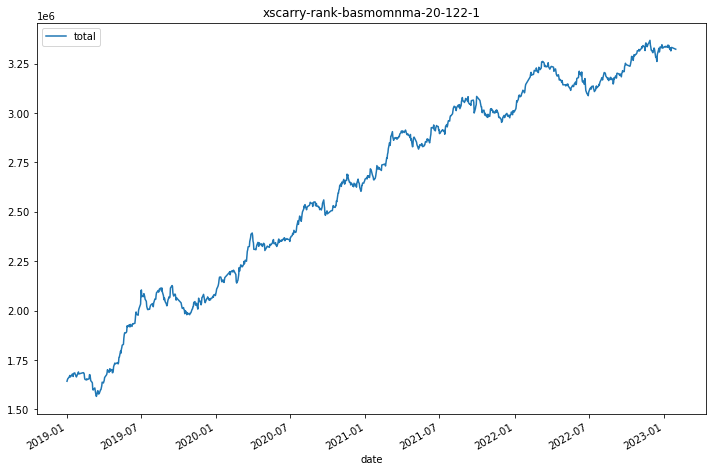

       sharpe       std  sortino
tenor                           
all      1.73  10760.54     2.68
6m       1.78  12147.08     2.83
1y       0.97  12132.66     1.50
2y       1.50  12754.49     2.28
3y       1.94  12816.64     3.01
4y       2.05  12887.66     3.30
5y       1.92  12916.90     3.03
6y       1.78  12714.56     2.85
7y       1.63  12435.38     2.61
8y       1.60  12089.67     2.56
9y       1.57  11714.43     2.51
10y      1.65  11348.74     2.62
11y      1.74  10944.42     2.71


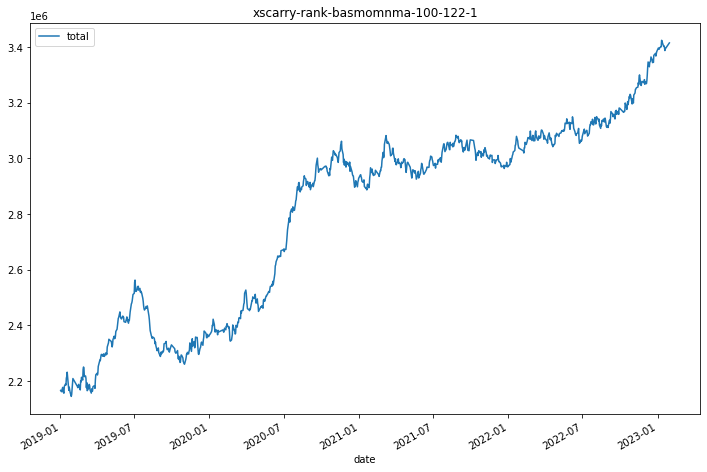

       sharpe       std  sortino
tenor                           
all      1.79  11004.50     2.88
6m       2.92  13233.61     5.26
1y       1.97  12616.43     3.40
2y       1.17  12454.59     1.93
3y       1.72  12972.10     2.85
4y       1.57  13013.55     2.62
5y       1.54  13282.91     2.50
6y       1.70  12802.03     2.78
7y       1.71  12709.67     2.86
8y       1.81  12310.74     3.00
9y       1.79  11880.24     2.95
10y      1.81  11495.18     2.97
11y      1.80  11059.78     2.91


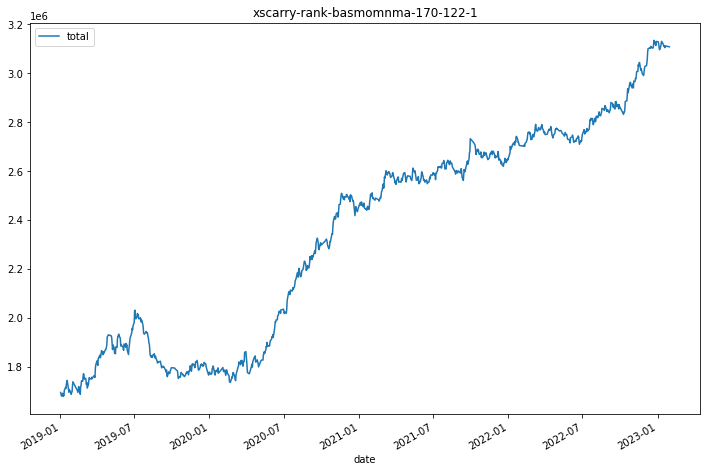

       sharpe       std  sortino
tenor                           
all      1.75  10495.23     2.83
6m       3.25  12619.11     5.79
1y       2.35  11275.75     3.90
2y       1.66  11792.10     2.90
3y       2.32  12337.42     3.99
4y       1.83  12485.77     3.13
5y       1.78  12503.55     2.96
6y       1.90  12045.21     3.16
7y       1.80  12009.87     3.03
8y       1.82  11616.83     3.01
9y       1.85  11199.54     3.03
10y      1.88  10855.24     3.07
11y      1.75  10495.23     2.83


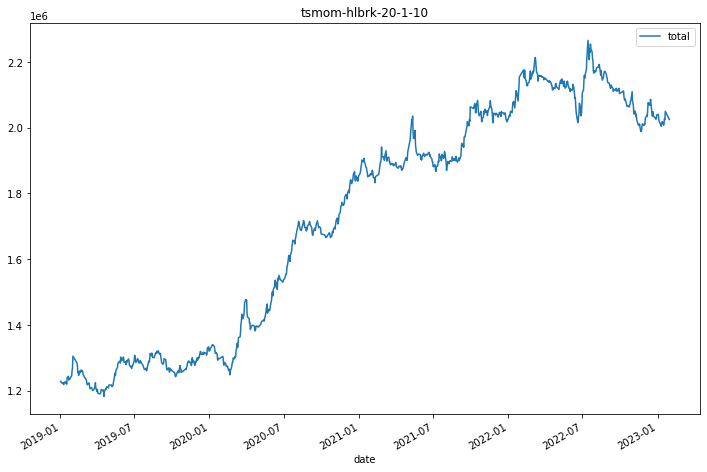

       sharpe       std  sortino
tenor                           
all      1.12   9650.92     1.65
6m      -1.74  10638.87    -2.25
1y      -0.64  13176.36    -0.92
2y       0.41  12996.56     0.61
3y       1.29  12178.82     1.87
4y       1.12  11258.06     1.65
5y       1.12  10714.61     1.66
6y       1.03  10504.03     1.56
7y       1.13  10677.45     1.77
8y       1.09  10685.46     1.65
9y       1.17  10422.54     1.77
10y      1.17  10115.65     1.77
11y      1.24   9852.54     1.86


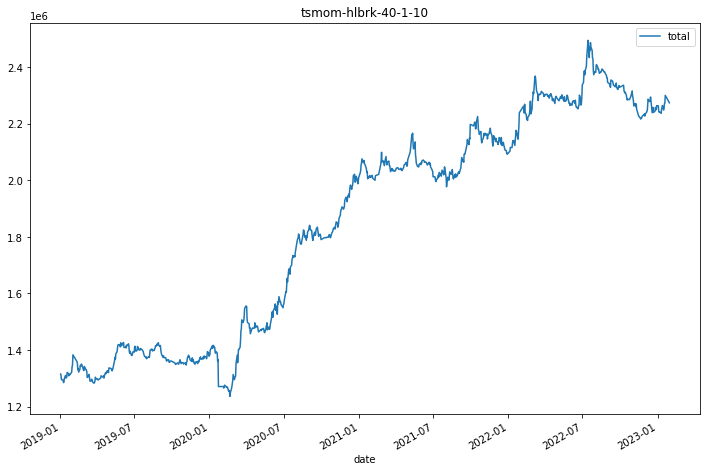

       sharpe       std  sortino
tenor                           
all      1.13  10710.17     1.64
6m      -1.26  10360.95    -1.77
1y       0.16  14155.13     0.24
2y       0.61  13822.21     0.94
3y       1.59  13594.35     2.48
4y       1.20  12851.53     1.70
5y       1.13  12074.04     1.63
6y       1.04  11780.69     1.53
7y       1.10  11864.50     1.67
8y       1.09  11884.45     1.60
9y       1.19  11583.29     1.75
10y      1.18  11268.00     1.74
11y      1.22  10968.44     1.79


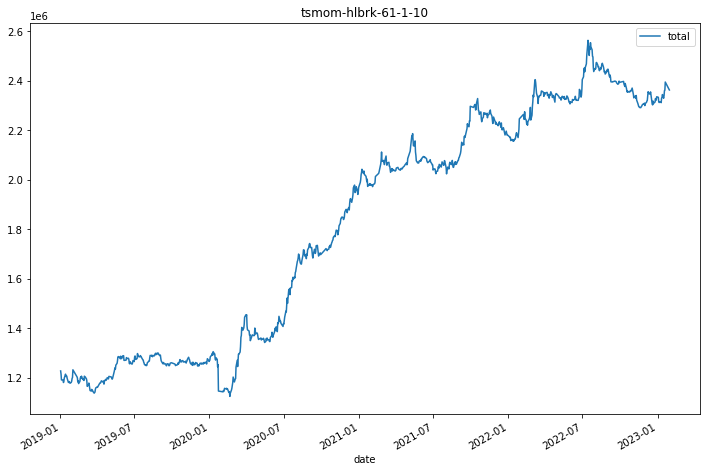

       sharpe       std  sortino
tenor                           
all      1.16  10886.47     1.67
6m      -0.93  10478.04    -1.29
1y       0.52  14769.51     0.76
2y       0.89  13976.57     1.36
3y       1.87  13978.03     2.95
4y       1.44  13217.25     2.01
5y       1.26  12406.56     1.78
6y       1.08  12136.88     1.57
7y       1.19  12173.02     1.78
8y       1.16  12067.97     1.69
9y       1.26  11768.61     1.85
10y      1.23  11447.84     1.79
11y      1.25  11138.94     1.82


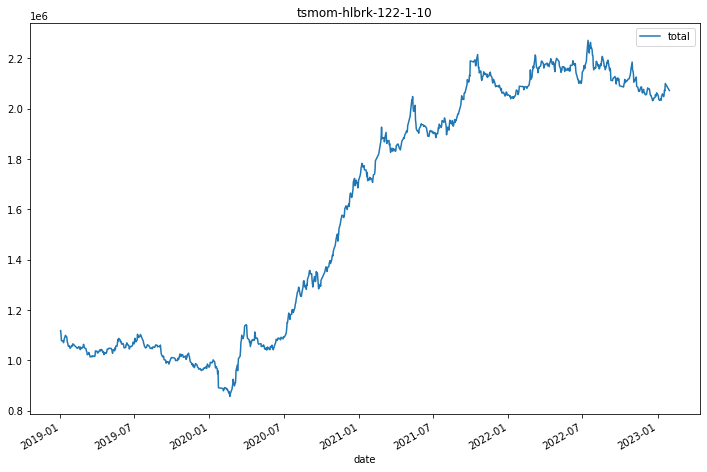

       sharpe       std  sortino
tenor                           
all      1.05  10549.28     1.49
6m      -0.85  12645.32    -1.18
1y      -0.08  13934.21    -0.11
2y       0.81  14063.85     1.17
3y       1.82  13933.23     2.74
4y       1.28  12778.75     1.85
5y       1.12  11943.45     1.62
6y       0.83  11568.06     1.21
7y       1.03  11670.88     1.56
8y       1.01  11769.80     1.50
9y       1.16  11494.12     1.72
10y      1.15  11196.02     1.69
11y      1.11  10813.40     1.60


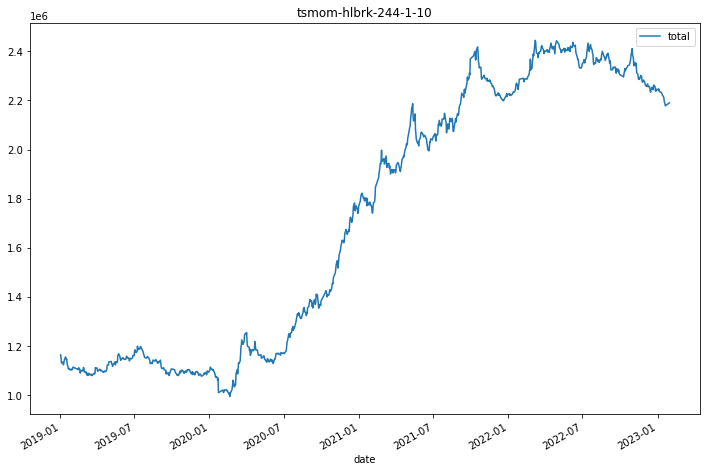

       sharpe       std  sortino
tenor                           
all      1.11  10515.31     1.54
6m      -1.89  10800.96    -2.77
1y      -0.51  12483.23    -0.76
2y       0.90  14919.46     1.38
3y       1.77  14324.72     2.73
4y       1.34  13032.65     1.99
5y       1.15  12065.08     1.68
6y       0.96  11513.37     1.40
7y       1.06  11611.51     1.58
8y       1.06  11985.61     1.56
9y       1.21  11614.74     1.76
10y      1.23  11321.20     1.79
11y      1.19  10992.54     1.72


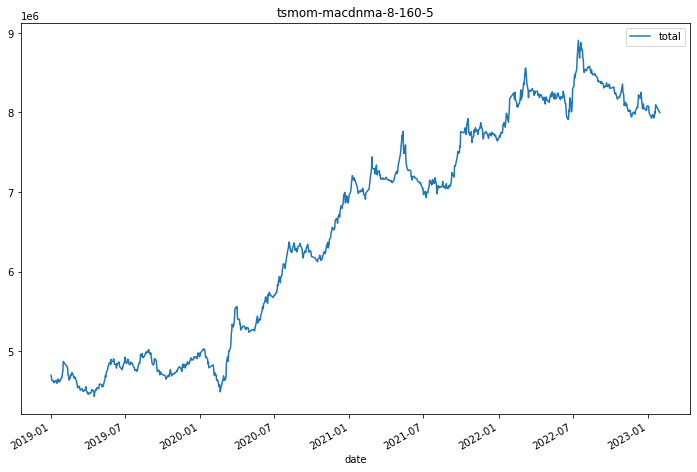

       sharpe       std  sortino
tenor                           
all      1.14  37279.27     1.67
6m      -1.72  38540.77    -2.15
1y      -0.22  53529.32    -0.32
2y       0.61  52224.34     0.90
3y       1.40  49264.42     2.09
4y       1.18  45315.40     1.78
5y       1.01  42858.99     1.52
6y       0.98  41671.56     1.50
7y       1.11  42714.30     1.75
8y       1.07  42379.21     1.63
9y       1.08  40740.30     1.63
10y      1.08  39550.39     1.63
11y      1.16  38476.45     1.74


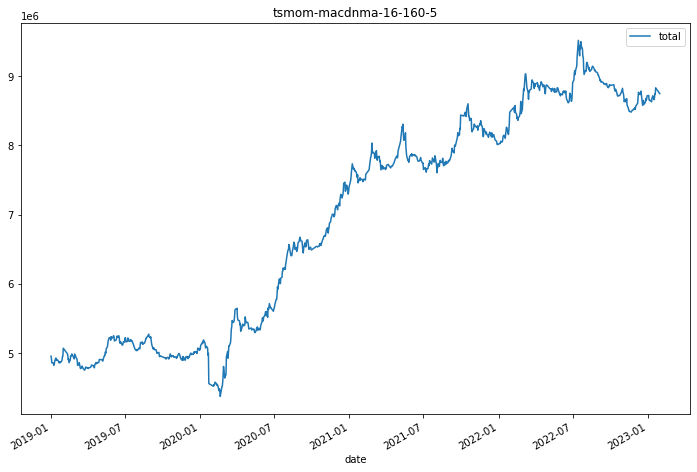

       sharpe       std  sortino
tenor                           
all      1.13  41261.81     1.57
6m      -0.96  37815.87    -1.36
1y       0.32  55804.05     0.46
2y       0.74  54521.38     1.09
3y       1.67  53988.08     2.52
4y       1.22  51035.84     1.64
5y       1.00  47898.14     1.38
6y       0.95  46490.36     1.34
7y       1.06  47374.68     1.54
8y       1.06  46910.92     1.51
9y       1.13  45127.64     1.61
10y      1.12  43868.47     1.59
11y      1.15  42584.22     1.63


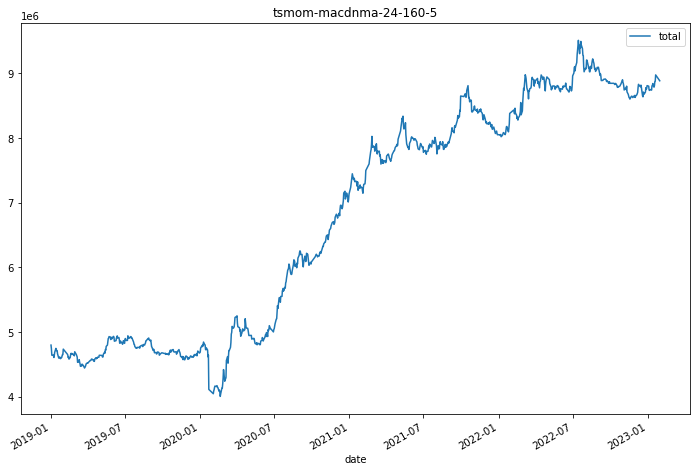

       sharpe       std  sortino
tenor                           
all      1.10  42984.86     1.49
6m      -0.45  40989.79    -0.65
1y       0.57  57969.77     0.84
2y       0.94  56511.50     1.42
3y       1.82  56262.74     2.82
4y       1.28  53646.27     1.68
5y       1.03  50203.92     1.37
6y       0.90  48667.41     1.22
7y       1.05  49345.40     1.47
8y       1.05  48797.93     1.47
9y       1.16  47048.58     1.61
10y      1.14  45701.69     1.58
11y      1.13  44324.60     1.57


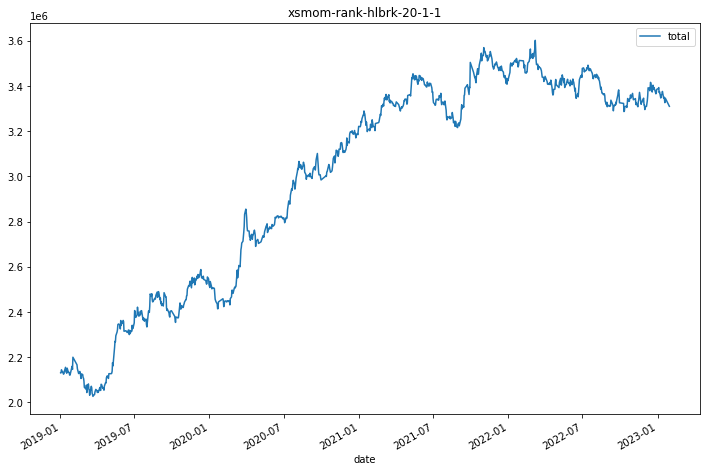

       sharpe       std  sortino
tenor                           
all      1.28  13892.19     2.06
6m      -1.10  15563.25    -1.57
1y      -0.79  16755.98    -1.16
2y       0.15  17479.62     0.24
3y       1.07  17308.54     1.73
4y       1.08  17417.87     1.78
5y       1.10  17057.16     1.83
6y       1.05  16413.09     1.76
7y       0.91  16174.42     1.51
8y       1.02  15718.88     1.70
9y       1.11  15353.70     1.86
10y      1.17  14805.07     1.92
11y      1.29  14351.55     2.11


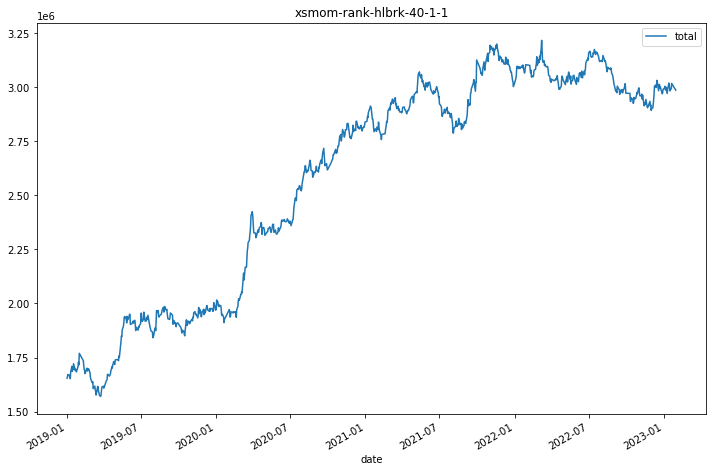

       sharpe       std  sortino
tenor                           
all      1.14  14178.01     1.81
6m      -1.11  15874.42    -1.60
1y      -0.46  16947.19    -0.69
2y       0.31  18149.06     0.51
3y       1.26  17983.91     2.06
4y       1.17  17640.08     1.96
5y       1.13  17393.34     1.91
6y       0.95  16712.37     1.59
7y       0.81  16429.64     1.34
8y       0.89  15973.61     1.48
9y       1.01  15633.78     1.67
10y      1.07  15057.31     1.73
11y      1.20  14609.26     1.92


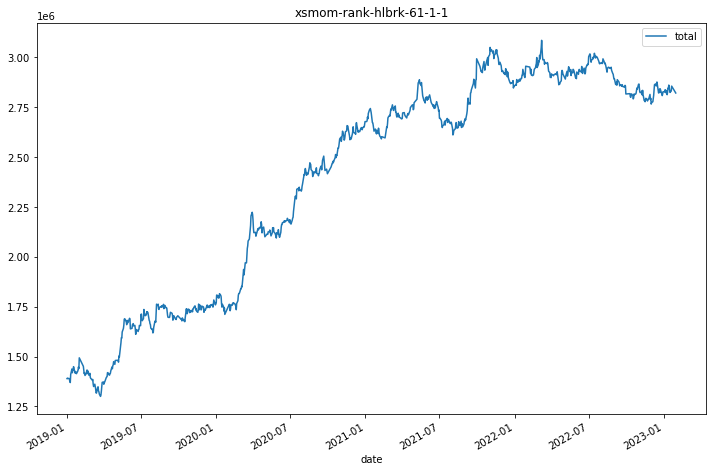

       sharpe       std  sortino
tenor                           
all      1.08  14155.73     1.74
6m      -1.31  14802.38    -1.81
1y      -0.53  16540.01    -0.78
2y       0.34  17816.38     0.57
3y       1.33  17900.50     2.27
4y       1.28  17569.73     2.20
5y       1.15  17224.94     1.96
6y       0.96  16655.61     1.61
7y       0.84  16338.25     1.40
8y       0.88  15868.99     1.46
9y       0.98  15524.25     1.63
10y      1.01  14958.56     1.64
11y      1.14  14530.64     1.85


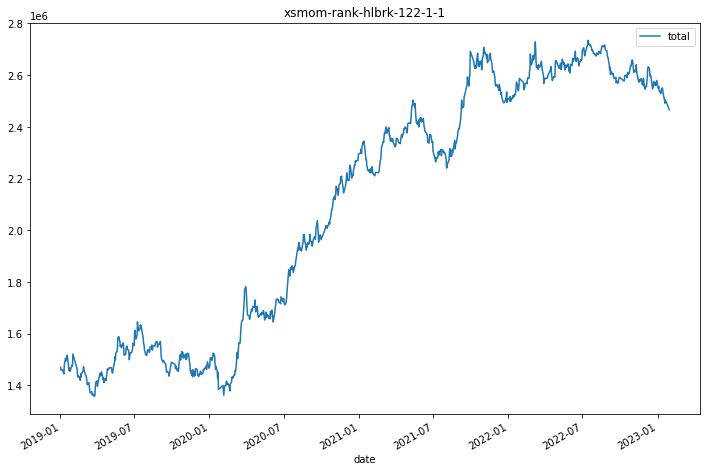

       sharpe       std  sortino
tenor                           
all      1.00  13774.24     1.53
6m      -2.14  13482.71    -3.01
1y      -0.50  15786.39    -0.73
2y       0.44  17023.21     0.71
3y       1.36  17101.33     2.24
4y       0.95  16820.75     1.54
5y       0.91  16451.89     1.46
6y       0.79  15920.80     1.24
7y       0.73  15785.16     1.15
8y       0.75  15343.71     1.18
9y       0.91  14966.58     1.44
10y      0.93  14440.71     1.46
11y      1.04  14030.35     1.61


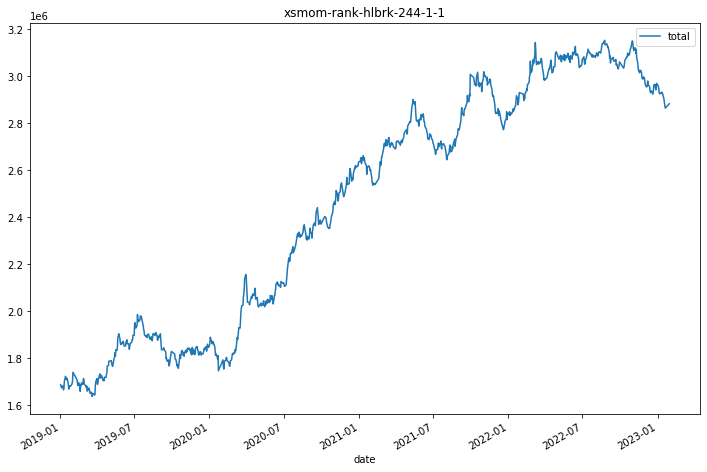

       sharpe       std  sortino
tenor                           
all      1.25  13452.63     1.92
6m      -2.15  12325.29    -3.24
1y      -0.20  15803.91    -0.29
2y       0.54  16791.20     0.90
3y       1.45  16838.23     2.41
4y       1.18  16370.35     1.95
5y       1.13  15780.86     1.85
6y       1.09  15377.69     1.76
7y       0.95  15255.61     1.52
8y       0.97  14840.83     1.55
9y       1.09  14393.50     1.73
10y      1.16  13866.92     1.80
11y      1.24  13483.11     1.92


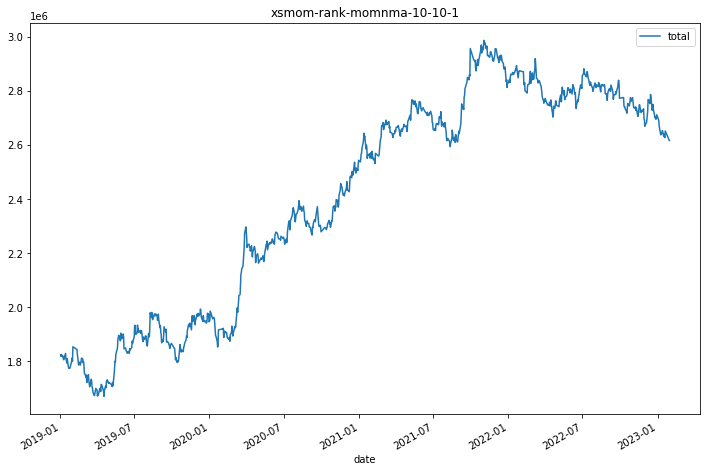

       sharpe       std  sortino
tenor                           
all      1.04  13556.29     1.69
6m      -1.66  15486.31    -2.29
1y      -1.03  16413.36    -1.57
2y       0.09  17126.64     0.14
3y       0.89  16970.38     1.44
4y       0.77  16972.46     1.30
5y       0.81  16650.67     1.36
6y       0.78  16059.47     1.32
7y       0.73  15769.21     1.24
8y       0.85  15320.25     1.44
9y       0.95  14941.65     1.59
10y      1.01  14390.06     1.68
11y      1.10  13976.15     1.81


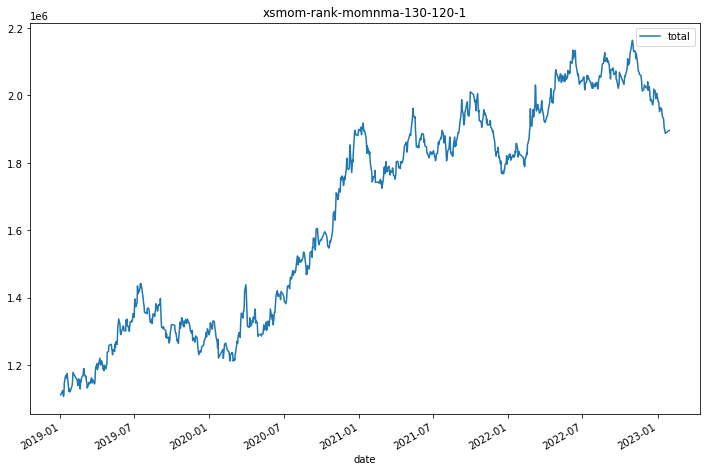

       sharpe       std  sortino
tenor                           
all      0.86  12911.03     1.31
6m      -1.31  13112.47    -2.09
1y       0.29  15927.98     0.45
2y       0.21  15704.94     0.32
3y       0.90  16118.80     1.42
4y       0.79  15660.78     1.26
5y       0.81  15146.30     1.30
6y       0.78  14846.52     1.24
7y       0.72  14700.82     1.14
8y       0.68  14241.60     1.09
9y       0.78  13804.41     1.23
10y      0.80  13276.46     1.24
11y      0.87  12928.33     1.33


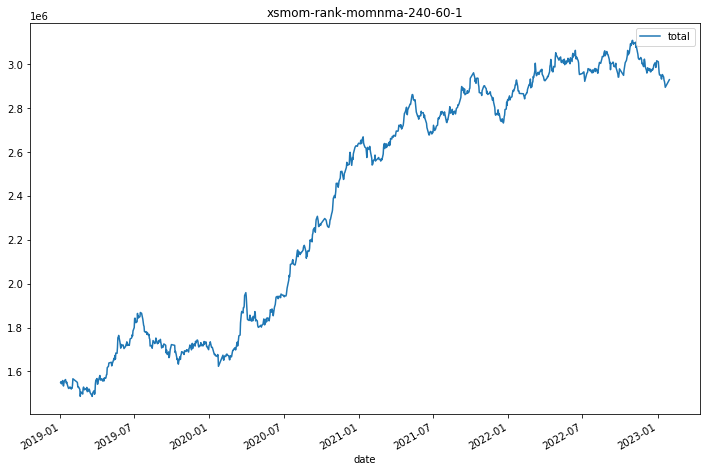

       sharpe       std  sortino
tenor                           
all      1.40  12435.00     2.20
6m      -0.41  13787.43    -0.67
1y       0.28  14614.57     0.43
2y       0.74  14497.04     1.17
3y       1.86  15048.25     3.03
4y       1.53  14820.26     2.45
5y       1.31  14353.18     2.10
6y       1.43  14193.30     2.32
7y       1.33  13941.16     2.15
8y       1.25  13556.66     2.02
9y       1.34  13110.19     2.14
10y      1.37  12662.45     2.16
11y      1.40  12435.00     2.20


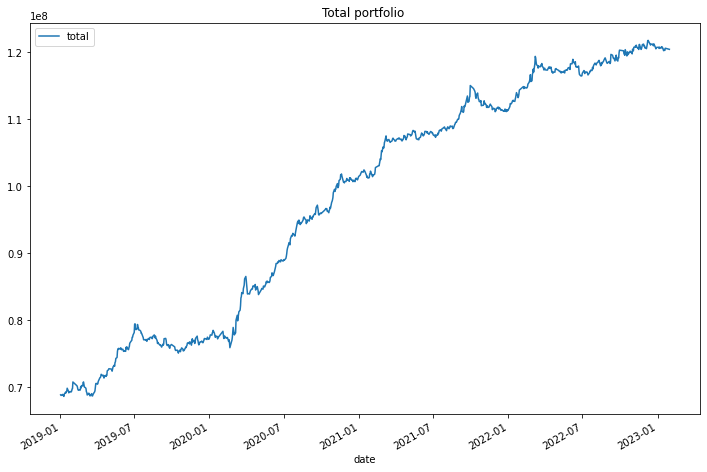

       sharpe        std  sortino
tenor                            
all      2.51  255557.68     4.04
6m       1.01  308299.95     1.89
1y       1.24  323017.32     2.05
2y       1.87  316978.02     3.16
3y       2.72  338764.81     4.54
4y       2.52  326945.79     4.33
5y       2.44  319820.97     4.06
6y       2.43  306999.05     4.03
7y       2.44  302175.51     4.07
8y       2.39  292212.26     3.96
9y       2.45  283566.51     4.06
10y      2.55  275081.33     4.20
11y      2.58  264219.79     4.18


In [32]:
start_date = datetime.date(2011,1,1)
end_date = datetime.date(2023,1,30)

shift_mode = 1
rev_char = '!'
exec_mode = 'open'
total_risk = 4600.0
asset_scaling = False
cost_ratio = 0.0
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenarios = scenarios_test

product_offsets = misc.product_trade_offsets(product_list)
run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names = []
scen_metrics = []
scen_stats = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['rev_char'] = rev_char
    run_args['cost_ratio'] = cost_ratio
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['xs_signal'] = ''
    run_args['xs_params'] = {'cutoff': 0.2}

    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    run_args['product_list'] = product_list

    run_args['signal_name'] = signal_name
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['rebal_freq'] = rebal
    run_args['params'] = params
    run_args['pos_map'] = pos_map
    run_args['xs_params'] = {'cutoff': 0.2}
    
    if 'xs' in sim_type:
        sim_split = sim_type.split('-')
        if len(sim_split)>1:
            run_args['xs_signal'] = sim_split[1]
        else:
            run_args['xs_signal'] = 'rank_cutoff'
    else:
        run_args['xs_signal'] = ''
    
    if len(scen) > 8:
        run_args['xs_params'] = {'cutoff': scen[8]}

    bt_metrics = run_backtest(df, run_args)
    scen_names.append(run_name)
    scen_metrics.append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors)
    scen_stats.append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='px', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg, offsets=product_offsets, cost_ratio=cost_ratio)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))

In [33]:
bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices)

print(asset_pnl.sum(axis=1)[-40:])

date
2022-11-28    -54727.450046
2022-11-29    -81519.774294
2022-11-30    -71194.813163
2022-12-01   -227626.552126
2022-12-02     51014.404094
2022-12-05   -102176.246063
2022-12-06    172990.597590
2022-12-07    421621.795535
2022-12-08    506247.428633
2022-12-09   -148394.415348
2022-12-12   -254154.277212
2022-12-13    -12248.124347
2022-12-14   -115885.538489
2022-12-15   -173517.284309
2022-12-16     94639.380684
2022-12-19     66337.242751
2022-12-20    -31092.879822
2022-12-21   -128287.824805
2022-12-22    -42187.872318
2022-12-23    286184.123996
2022-12-26   -434485.331626
2022-12-27   -160665.698424
2022-12-28   -181752.960675
2022-12-29    101052.840765
2022-12-30     15733.886418
2023-01-03     75106.879387
2023-01-04     41651.873760
2023-01-05   -156549.820830
2023-01-06    106431.333451
2023-01-09    -11939.247357
2023-01-10    -30071.588266
2023-01-11    236133.904220
2023-01-12   -189519.097371
2023-01-13    198721.219120
2023-01-16   -719804.768395
2023-01-17    1

# holding and std for strategy group

In [29]:
file_folder = "C:\\dev\\data\\data_cache\\"

port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product             rb          hc            i           j          jm  \
date                                                                      
2011-01-05    0.000000    0.000000     0.000000    0.000000    0.000000   
2011-01-06    0.000000    0.000000     0.000000    0.000000    0.000000   
2011-01-07    0.000000    0.000000     0.000000    0.000000    0.000000   
2011-01-10    0.000000    0.000000     0.000000    0.000000    0.000000   
2011-01-11    0.000000    0.000000     0.000000    0.000000    0.000000   
...                ...         ...          ...         ...         ...   
2023-01-17  163.466118  313.326345  2355.492044  484.782352  757.975281   
2023-01-18  335.392935  445.985435  2170.554706  448.427980  513.957404   
2023-01-19  381.525103  474.441898  1535.965709  606.547628  707.385953   
2023-01-20  511.171918  774.978302  1186.807461  514.760955  861.738367   
2023-01-30  217.472984  304.545210  1551.624426  563.625533  496.352744   

product             ru  

In [42]:
tenors = ['1y', '2y', '3y']
data_list = []

for scen_name, scen, pl_stat in zip(scen_names, scenarios, scen_stats):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

weight        std_1y        std_2y  \
strat_name                                                             
tscarry-ryieldnmb-1-122-1          1.000  59958.844496  52972.148554   
tscarry-ryieldqtl-1-20-1           0.800  22308.201791  20676.812166   
tscarry-ryieldqtl-1-60-1           0.800  22044.750899  21173.524424   
tscarry-ryieldqtl-1-244-1          0.800  22214.861334  20236.013754   
tscarry-basmomnma-20-122-1         0.500  41547.456701  37787.004886   
tscarry-basmomnma-60-122-1         0.420  53983.494944  47478.847699   
tscarry-basmomnma-120-122-1        0.350  62030.564910  59031.743114   
tscarry-basmomnma-180-122-1        0.350  64844.154112  68541.253951   
tscarry-basmomqtl-120-20-1         2.000  23508.981933  21472.099736   
tscarry-basmomqtl-240-20-1         1.800  21162.263714  20335.226153   
xscarry-rank-ryieldnma-1-20-1      1.400  13351.800809  13967.715568   
xscarry-rank-ryieldnma-1-122-1     1.400  14485.473341  14636.681450   
xscarry-rank-ryieldnma-1-244-1     1.400  14480.557271  14538.695852   
xscarry-rank-basmomnma-20-122-1    2.000  12184.906523  12801.984507   
xscarry-rank-basmomnma-100-122-1   2.000  12599.312117  12500.853318   
xscarry-rank-basmomnma-170-122-1   2.000  11312.445766  11833.025119   
tsmom-hlbrk-20-1-10                0.500  13266.567795  12835.616122   
tsmom-hlbrk-40-1-10                0.500  14383.887050  13681.878851   
tsmom-hlbrk-61-1-10                0.500  14679.889937  13820.970041   
tsmom-hlbrk-122-1-10               0.500  13648.301694  13988.349749   
tsmom-hlbrk-244-1-10               0.500  12516.612426  14976.333730   
tsmom-macdnma-8-160-5              0.220  53745.714472  51576.107362   
tsmom-macdnma-16-160-5             0.200  56378.320801  54235.943732   
tsmom-macdnma-24-160-5             0.180  58030.181639  56336.637955   
xsmom-rank-hlbrk-20-1-1            0.375  16521.859561  17351.662602   
xsmom-rank-hlbrk-40-1-1            0.375  16755.996418  18039.710553   
xsmom-rank-hlbrk-61-1-1            0.375  16557.668725  17662.565669   
xsmom-rank-hlbrk-122-1-1           0.375  15726.085386  16878.343059   
xsmom-rank-hlbrk-244-1-1           0.375  15954.674469  16818.160977   
xsmom-rank-momnma-10-10-1          0.600  16217.779447  17033.900503   
xsmom-rank-momnma-130-120-1        0.600  15948.173746  15764.879171   
xsmom-rank-momnma-240-60-1         0.600  14497.347584  14480.864549   

                                        std_3y  sharpe_1y  sharpe_2y  \
strat_name                                                             
tscarry-ryieldnmb-1-122-1         49226.755606   0.564785   1.135205   
tscarry-ryieldqtl-1-20-1          21386.946871   1.483692   2.016004   
tscarry-ryieldqtl-1-60-1          23975.448646   0.307538   0.882522   
tscarry-ryieldqtl-1-244-1         24687.154916  -0.162638   0.397494   
tscarry-basmomnma-20-122-1        39533.938236   0.807254   1.508718   
tscarry-basmomnma-60-122-1        50189.576920   1.129291   0.919494   
tscarry-basmomnma-120-122-1       60094.546134   1.633569   1.185924   
tscarry-basmomnma-180-122-1       68048.459568   2.641886   1.691493   
tscarry-basmomqtl-120-20-1        22116.669396   0.934067   2.049656   
tscarry-basmomqtl-240-20-1        21057.765892   0.589444   1.657945   
xscarry-rank-ryieldnma-1-20-1     15211.895527  -0.042363   0.116045   
xscarry-rank-ryieldnma-1-122-1    15214.841929   1.202606   0.925633   
xscarry-rank-ryieldnma-1-244-1    14888.637266   1.170161   0.822217   
xscarry-rank-basmomnma-20-122-1   12833.723438   1.068268   1.563639   
xscarry-rank-basmomnma-100-122-1  12959.883967   1.657058   1.236616   
xscarry-rank-basmomnma-170-122-1  12365.729312   2.140260   1.759204   
tsmom-hlbrk-20-1-10               12109.742156  -0.305743   0.383926   
tsmom-hlbrk-40-1-10               14016.139394   0.546784   0.569280   
tsmom-hlbrk-61-1-10               14469.244262   0.875168   0.855878   
tsmom-hlbrk-122-1-10              14090.019326   0.103713   0.760859   
t

# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.885920  1.150439  1.056880  0.582261  0.598617  0.362051   
sharpe_6m  -0.753815 -0.479297  2.299305  0.077732  0.879762 -0.237651   
sharpe_1y   0.392825  0.786109  0.924386 -0.440629  0.329285  0.901438   
sharpe_2y   0.404019  0.581505  0.660337 -0.130156  0.997043  0.473889   
sharpe_3y   1.187177  1.553861  1.658023 -0.537418  1.027524  0.080169   
sharpe_4y   0.965897  1.192290  1.457681 -0.246223  0.518010  0.138792   
sharpe_5y   0.792740  0.953507  1.274071 -0.187275  0.500566  0.506400   
sharpe_6y   0.830136  0.938449  1.098845  0.168944  0.416067  0.653913   
sharpe_7y   0.728290  1.078642  1.197322  0.196565  0.670583  0.448097   
sharpe_8y   0.919091  1.211904  1.105901  0.577476  0.597287  0.319122   
sharpe_9y   1.034478  1.150439  1.073731  0.674006  0.626076  0.340758   
sharpe_10y  0.911836  1.150439  1.056880  0.643795  0.598617  0.448247   
sharpe_11y  0.885920  1.150439  1.0568

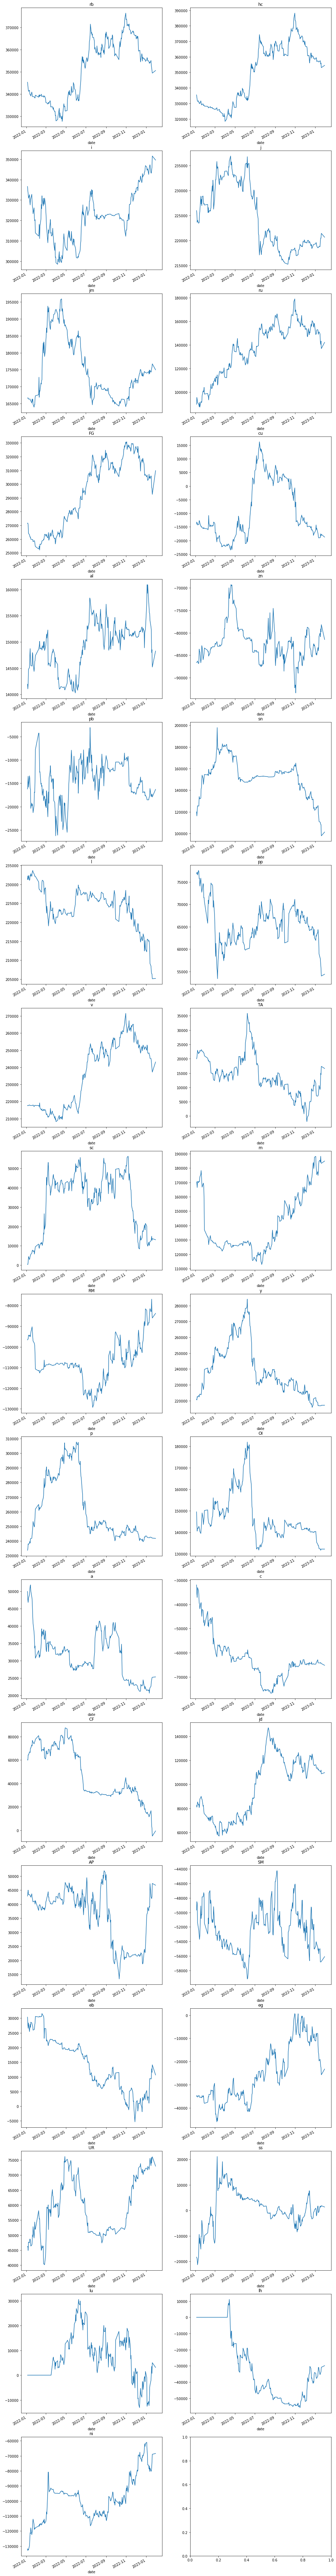

In [30]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2022-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


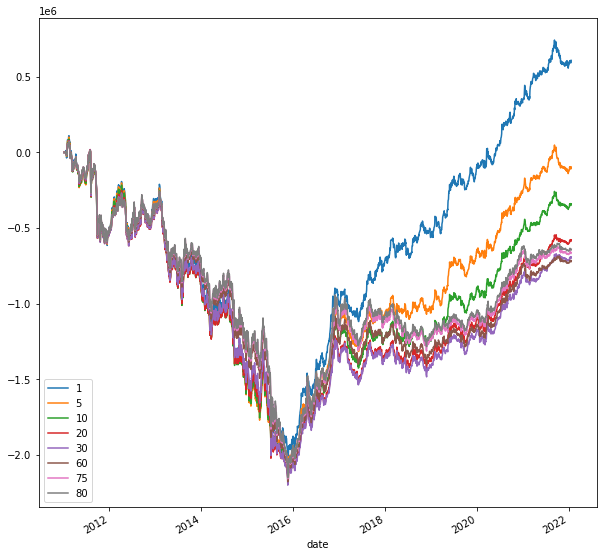

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


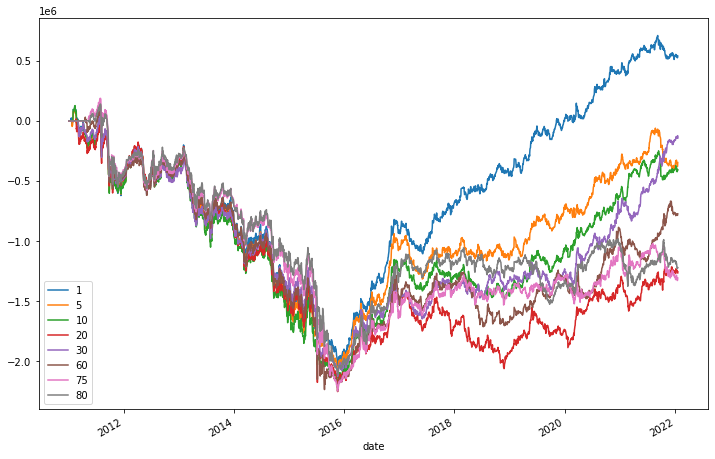

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

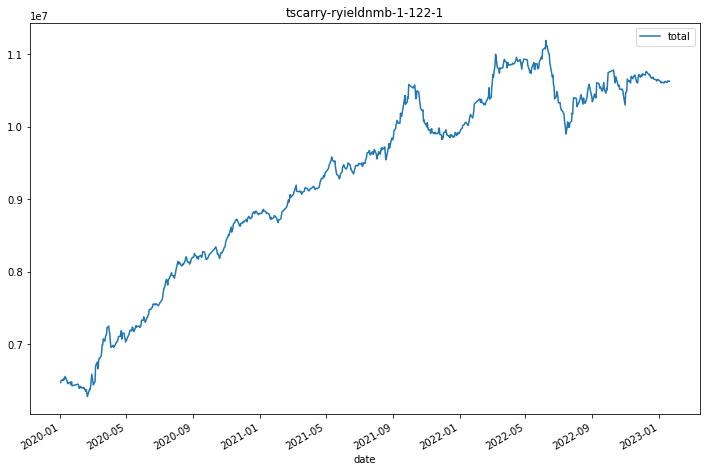

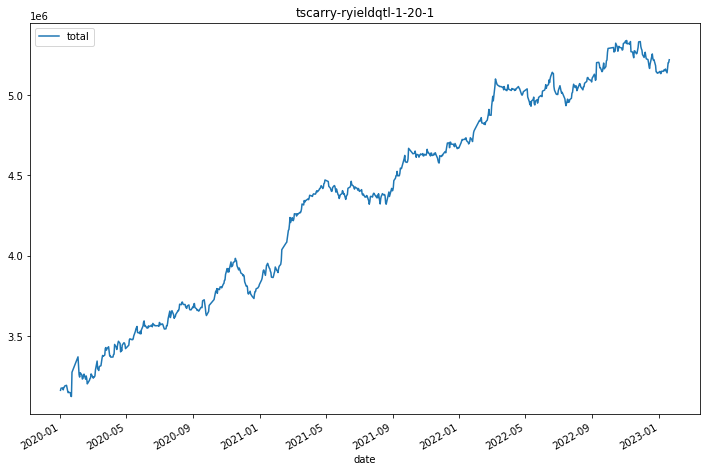

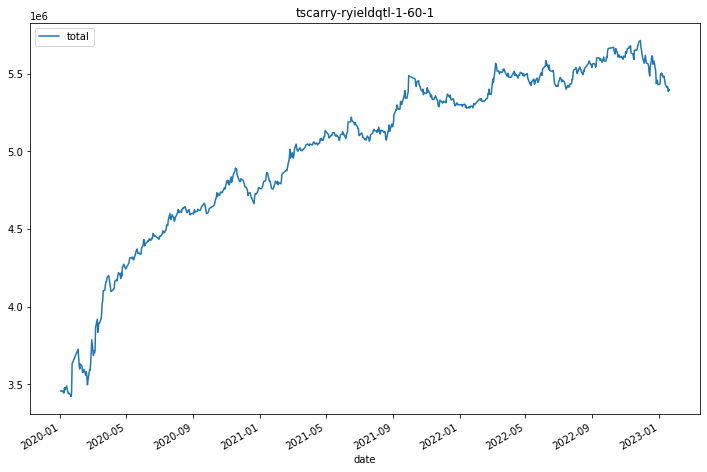

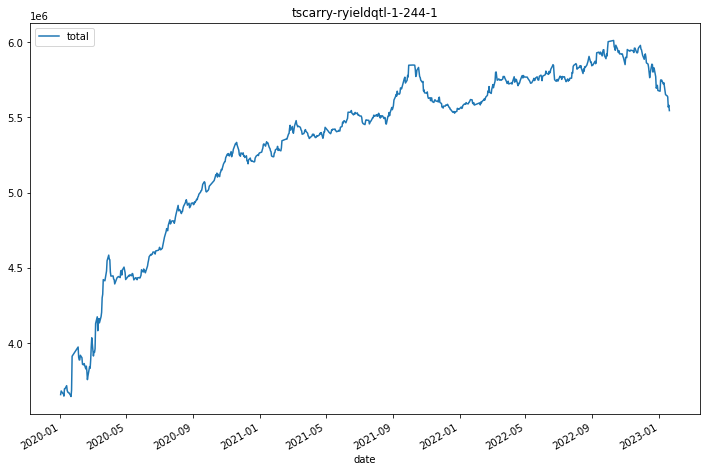

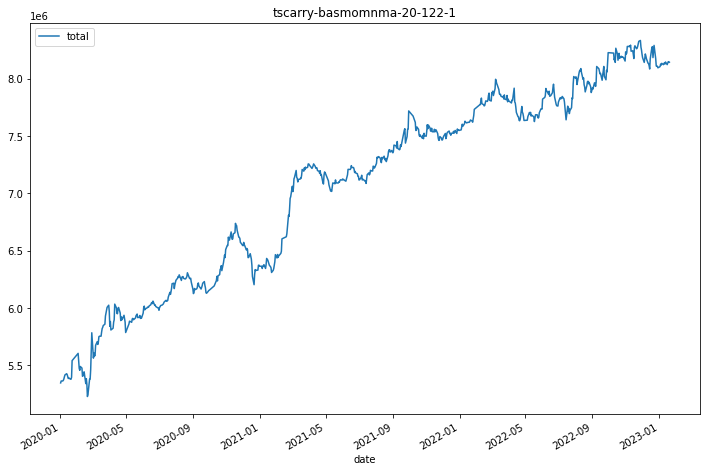

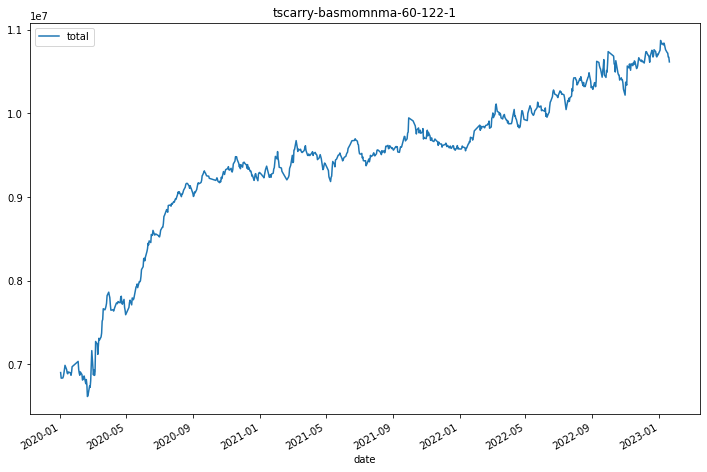

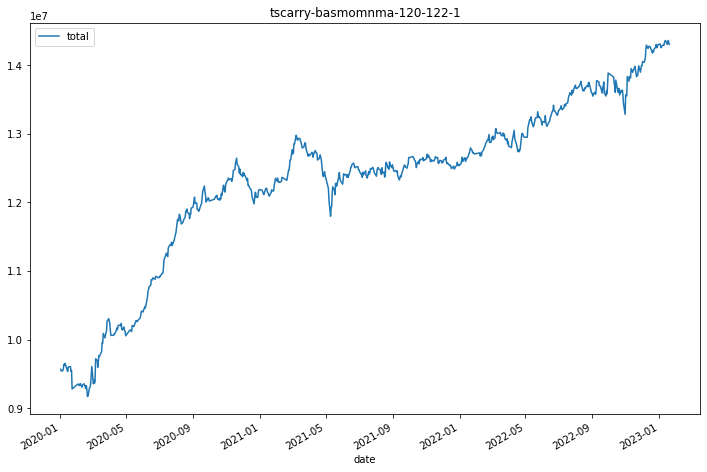

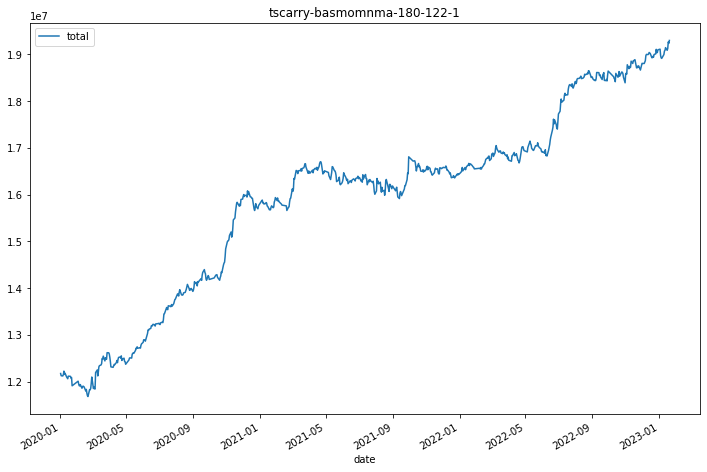

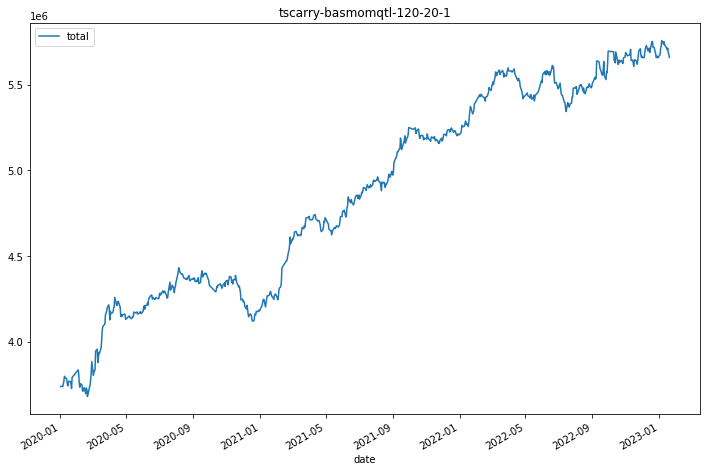

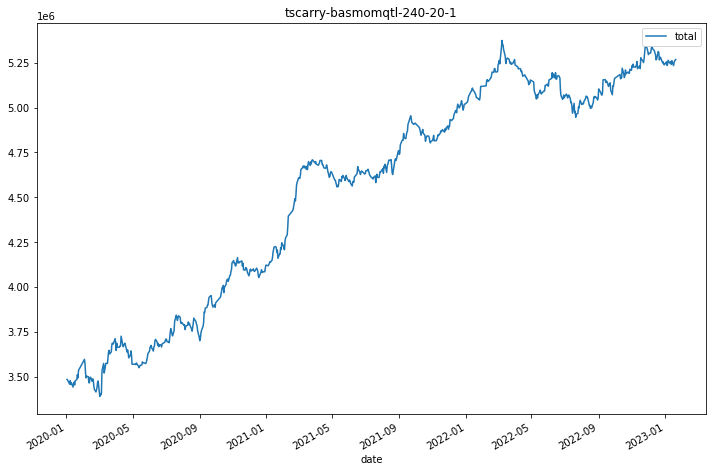

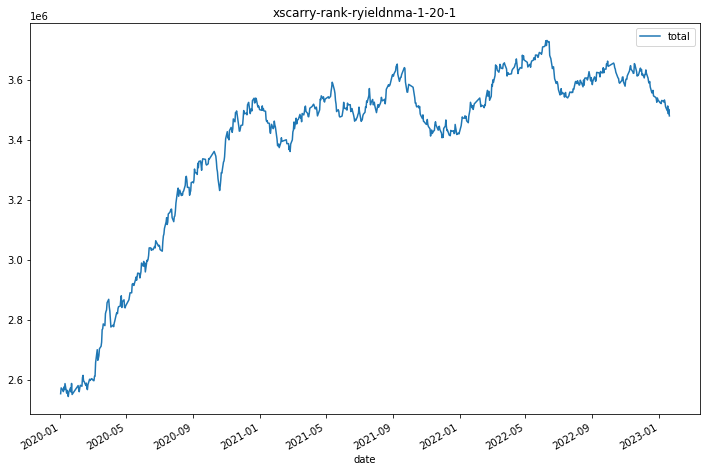

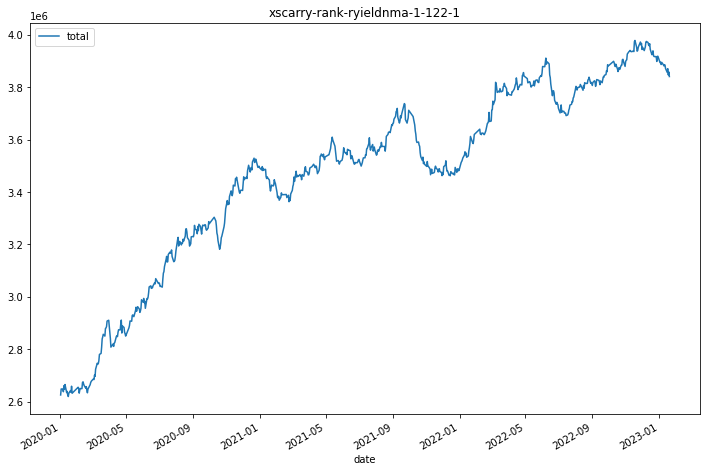

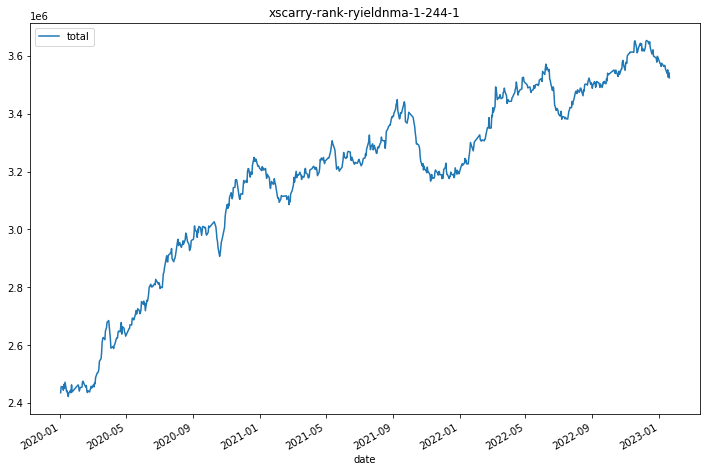

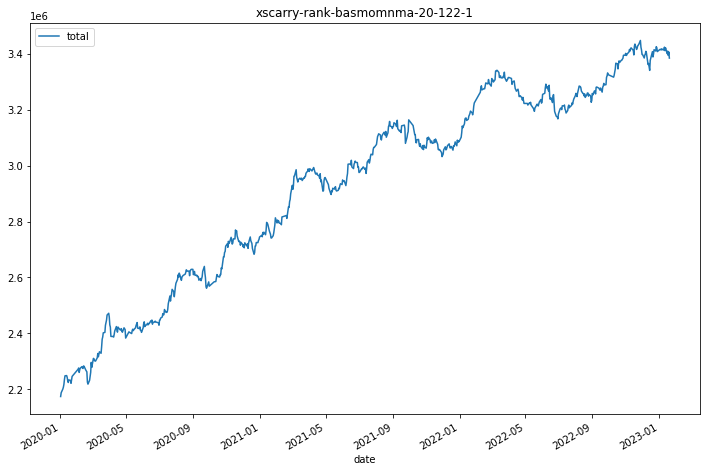

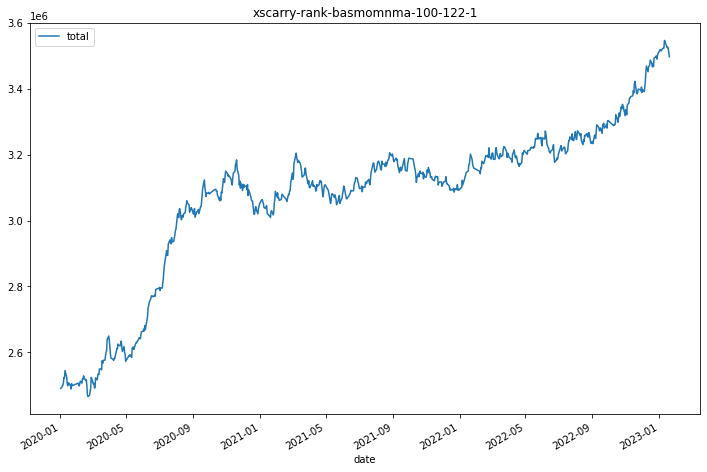

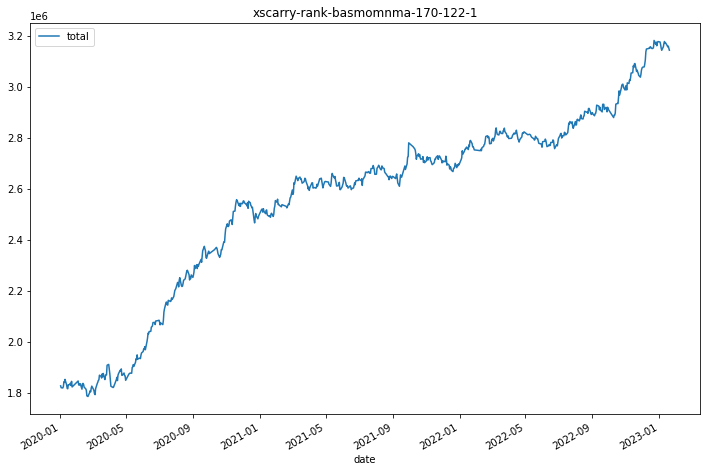

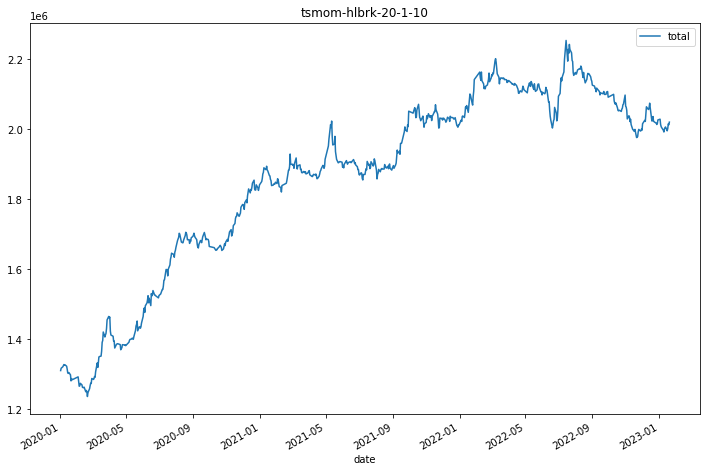

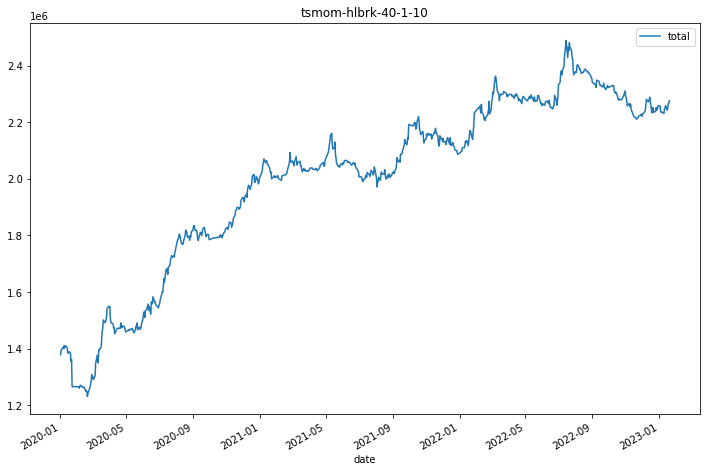

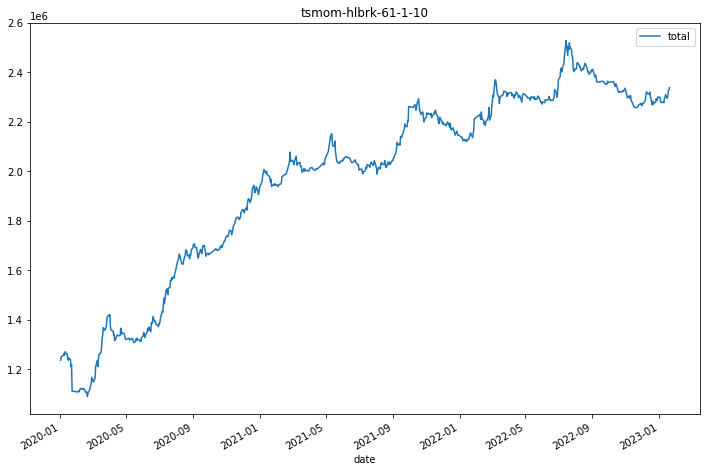

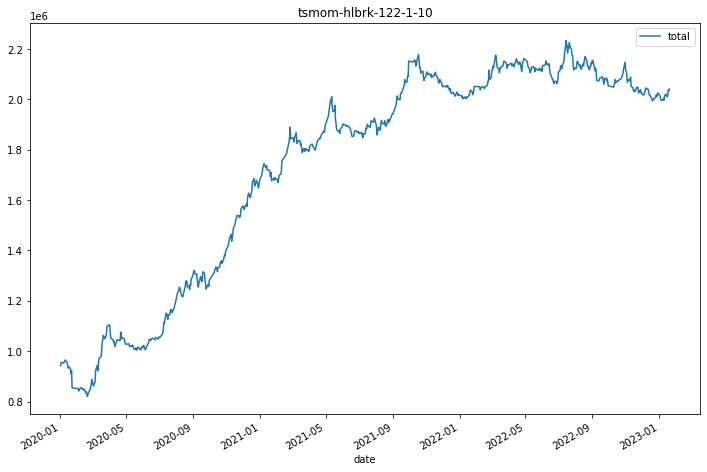

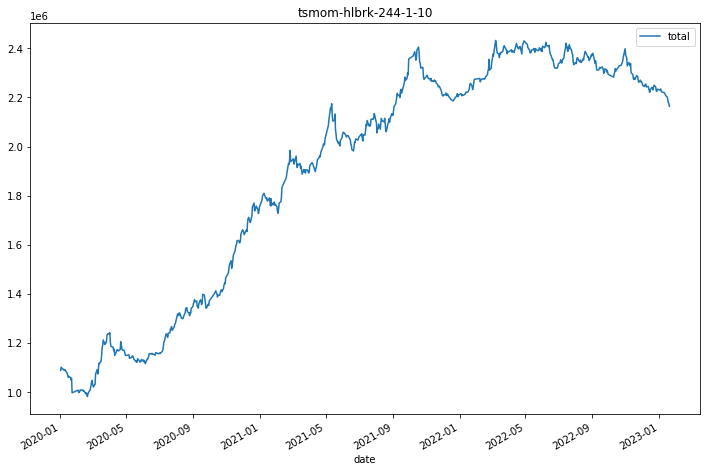

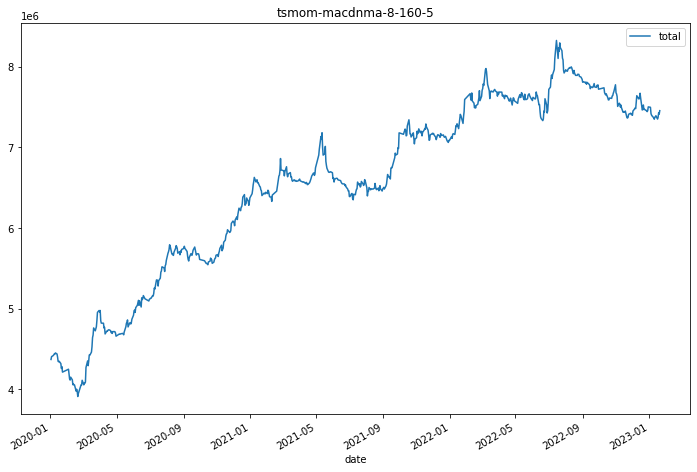

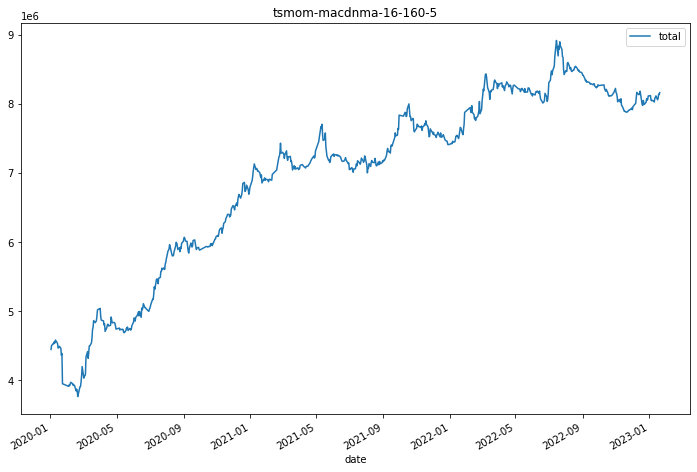

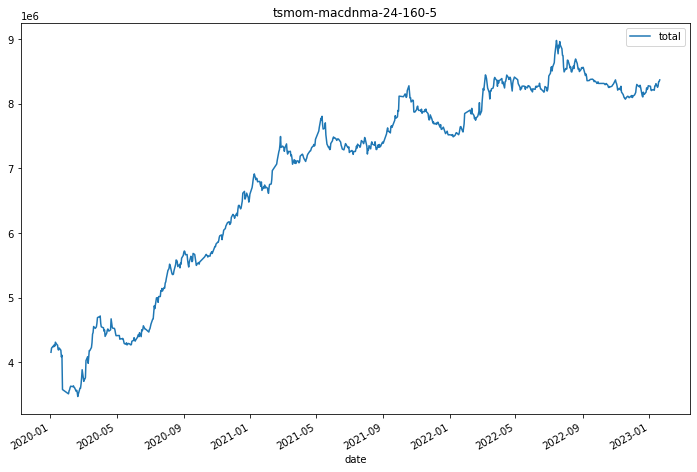

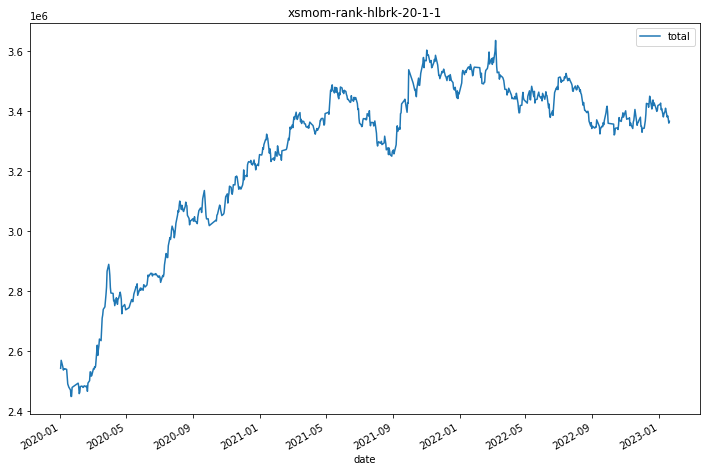

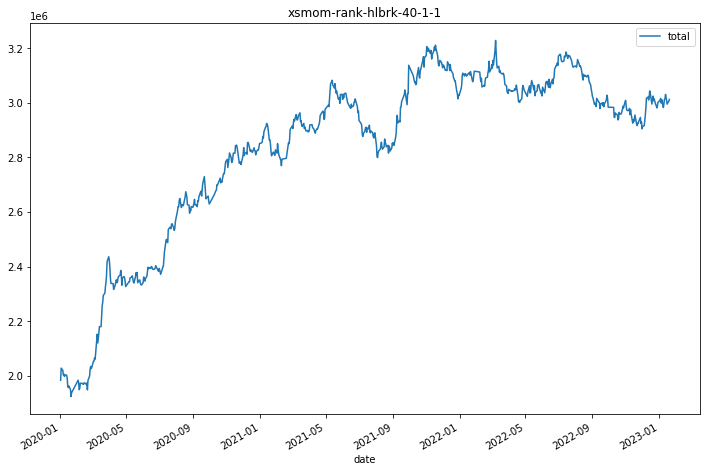

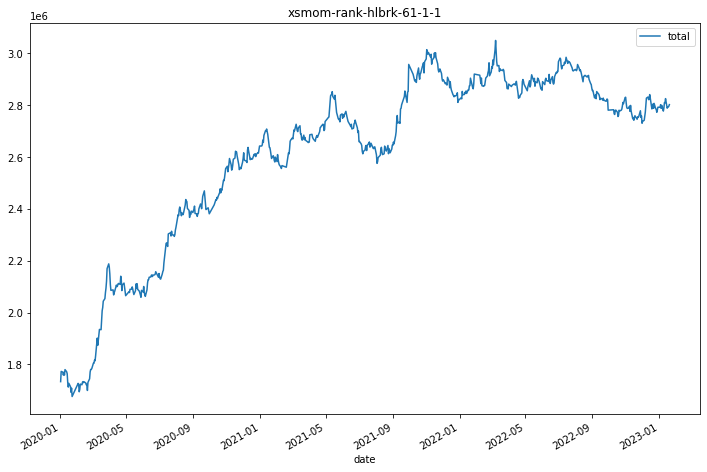

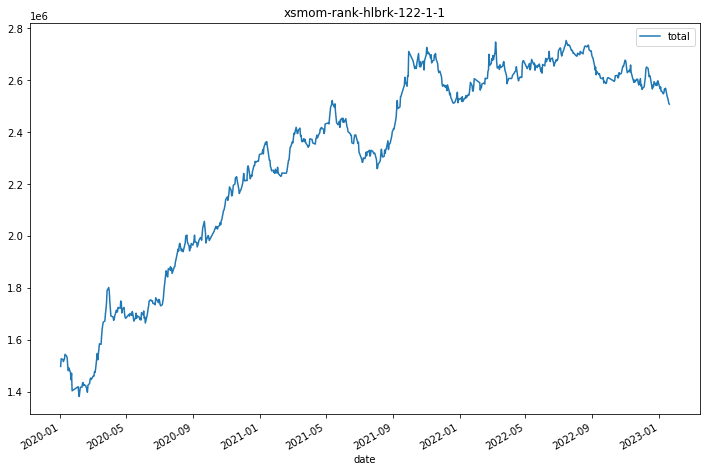

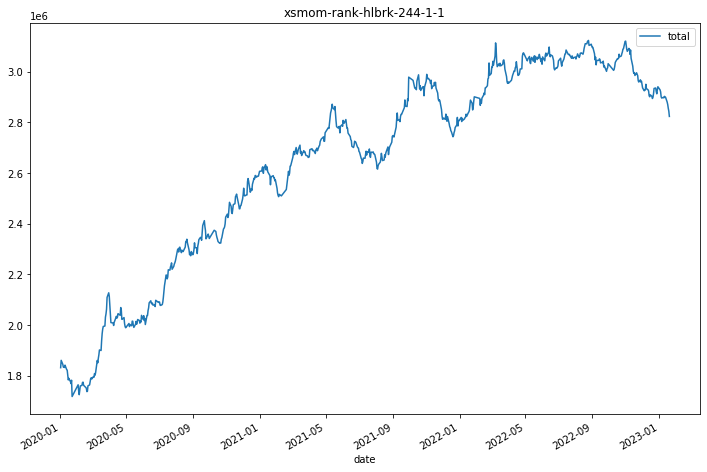

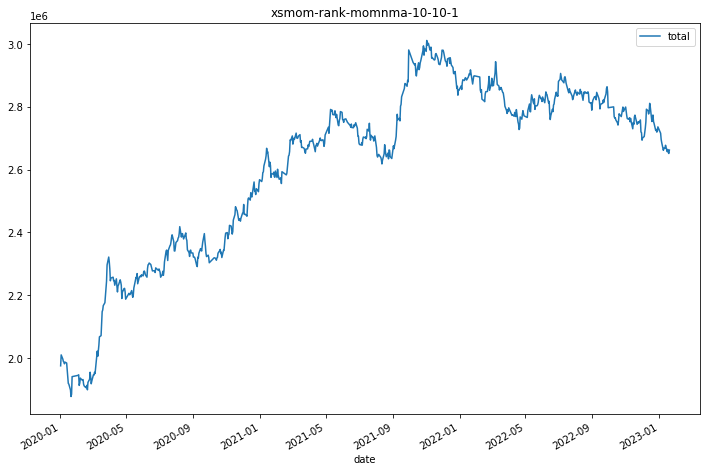

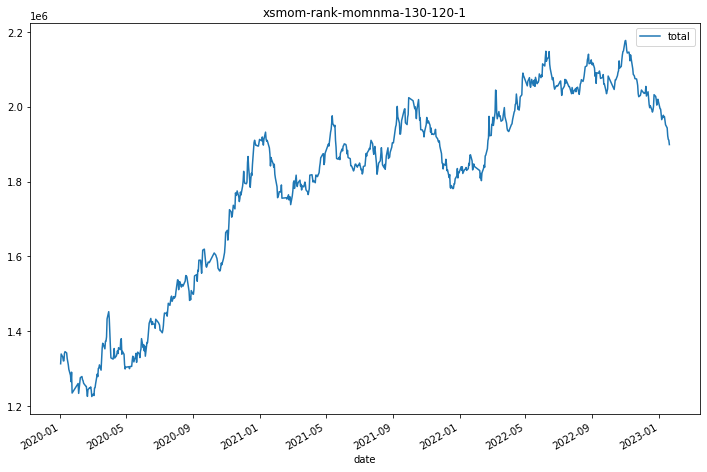

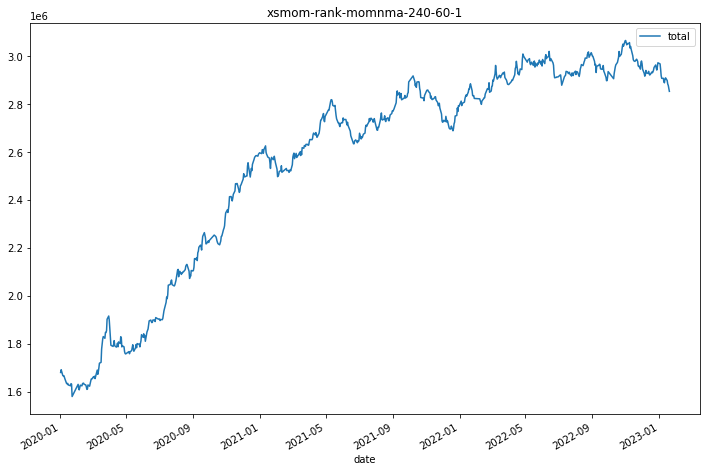

In [46]:
scen_start = pd.to_datetime('2020-01-01')
df_list = []
for scen_name, scen_stat in zip(scen_names, scen_stats):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
